In [1]:
import torch
from tqdm.notebook import tqdm
import torchvision.models as models
import torch.nn.functional as F
import os
from data.DataLoader import ImageNetDataset, load_data
import cv2
import torchvision.transforms as transforms
from attack import fgsm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from utils import Accuracy
from PIL import Image
%matplotlib inline

PROJ_DIR = os.getcwd()
TRAIN_VAL_PATH = os.path.join(PROJ_DIR, 'data', 'train_val')
TEST_PATH = os.path.join(PROJ_DIR, 'data', 'DAmageNet')
TRAIN_IMG_DIR = os.path.join(TRAIN_VAL_PATH, 'train')
VAL_IMG_DIR = os.path.join(TRAIN_VAL_PATH, 'val')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

img = Image.open('./compare.png').convert('RGB')
img = transform(img)
print(img.shape)

torch.Size([3, 224, 224])


In [2]:
with open('imagenet_classes.txt', 'r') as f:
    imagenet_classes = f.readlines()
    imagenet_classes_short = [x.strip().split(',')[-1]
                              for x in imagenet_classes]

In [3]:
def plot_top_classes(values, top_k=5):
    sorted_classes = np.argsort(-values)
    class_ids = sorted_classes[:top_k]
    class_names = [imagenet_classes_short[it] for it in list(class_ids)]
    class_values = values[class_ids]
    plt.bar(class_names, class_values)
    plt.xticks(rotation=60)
    return class_names[0]

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def prepare_image(image_cv2, do_normalize=True):
    # Resize
    img = cv2.resize(image_cv2, (224, 224))
    img = img[:, :, ::-1].copy()
    # Convert to tensor
    tensor_img = transforms.functional.to_tensor(img)

    # Possibly normalize
    if do_normalize:
        tensor_img = normalize(tensor_img)
    # Put image in a batch
    batch_tensor_img = torch.unsqueeze(tensor_img, 0).to(device)

    return batch_tensor_img


def UnNormalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]):
    std_arr = torch.tensor(std)[:, None, None]
    mean_arr = torch.tensor(mean)[:, None, None]

    def func(img):
        img = img.clone()
        img *= std_arr
        img += mean_arr
        return img
    return func


unnormalize = UnNormalize()


def obtain_image(tensor_img, do_normalize=True):
    tensor_img = tensor_img.cpu()
    if do_normalize:
        tensor_img = unnormalize(tensor_img)
    img = transforms.functional.to_pil_image((tensor_img.data))
    return img

In [5]:
dataset = ImageNetDataset(TRAIN_IMG_DIR, os.path.join(TRAIN_VAL_PATH, 'train.txt'), None)

img, label, attack = dataset[1]
print(imagenet_classes_short[label])

hamster


In [6]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT).to(device)
model.eval()
loss = nn.CrossEntropyLoss()
starting_img = prepare_image(img, do_normalize=False)
input_img = starting_img.clone().requires_grad_(True)

'hamster'

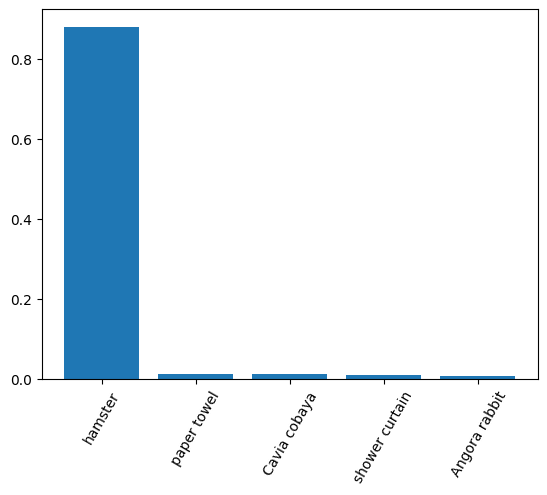

In [7]:
output = model(input_img)
prob = F.softmax(output, dim=1)
plot_top_classes(prob[0,:].data.cpu().numpy())

In [8]:
attacked_res = fgsm(input_img, torch.tensor([label]), model, loss, epsilon=0.01)
original_img = obtain_image(starting_img[0, :], do_normalize=False)
attacked_img = obtain_image(attacked_res[0, :], do_normalize=False)

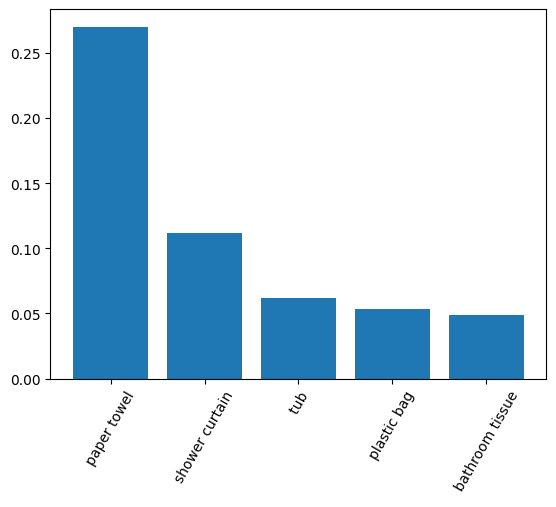

In [9]:
output = model(attacked_res)
prob = F.softmax(output, dim=1)
pred = plot_top_classes(prob[0,:].data.cpu().numpy())

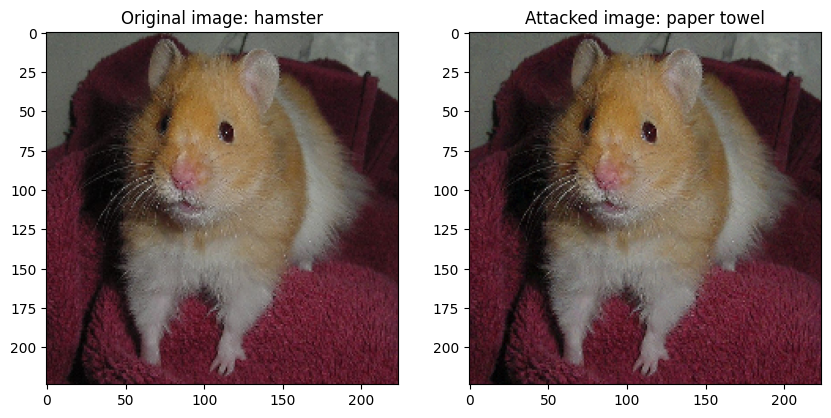

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original image: ' + imagenet_classes_short[label] + '')
axs[0].imshow(original_img)
axs[1].set_title('Attacked image: ' + pred + '')
axs[1].imshow(attacked_img)

# Generate all attacks

In [2]:
classifiers = [{'model': models.resnet34(weights=models.ResNet34_Weights.DEFAULT).to(device).eval(), 'name': 'resnet34'},
               {'model':  models.resnet50(
                   weights=models.ResNet50_Weights.DEFAULT).to(device).eval(), 'name': 'resnet50'},
               {'model':  models.resnet101(
                   weights=models.ResNet101_Weights.DEFAULT).to(device).eval(), 'name': 'resnet101'},
               {'model': models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT).to(device).eval(), 'name': 'inception_v3'}]
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
loss = nn.CrossEntropyLoss()
BATCH_SIZE = 32

origin_loader = load_data('val', batch_size=BATCH_SIZE, apply_trans=True)
data_loader = load_data('val', batch_size=BATCH_SIZE, apply_trans=False)
for classifier in classifiers:
    if classifier['name'] != 'inception_v3':
        continue
    no_attack = Accuracy()
    model = classifier['model']
    for i, (data, labels, attacked_data) in enumerate(tqdm(origin_loader)):
        data = data.to(device)
        labels = labels.to(device)
        logits = model(data)
        probs = F.softmax(logits, dim=1)
        _, pred = torch.max(probs, dim=1)
        no_attack.update(torch.sum(pred == labels).item(), BATCH_SIZE)
    print('Classifier: {}, Original accuracy: {:.2f}%'.format(
        classifier['name'], no_attack.avg * 100))
    for epsilon in epsilons:
        attack = Accuracy()
        for i, (data, labels, attacked_data) in enumerate(tqdm(data_loader)):
            data = data.to(device)
            labels = labels.to(device)
            input_img = data.clone().requires_grad_(True)
            attacked_res = fgsm(input_img, labels,
                                model, loss, epsilon=epsilon)
            logits = model(attacked_res)
            probs = F.softmax(logits, dim=1)
            _, pred = torch.max(probs, dim=1)
            attack.update(torch.sum(pred == labels).item(), BATCH_SIZE)
        print('Epsilon: {}, Attack accuracy: {:.2f}%'.format(
            epsilon, attack.avg * 100))

Loading data from ./data/train_val/val.txt
Length of val set is: 5000
Loading data from ./data/train_val/val.txt
Length of val set is: 5000


  0%|          | 0/157 [00:00<?, ?it/s]

Classifier: inception_v3, Original accuracy: 70.02%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.05, Attack accuracy: 4.38%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.1, Attack accuracy: 4.06%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.15, Attack accuracy: 3.09%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.2, Attack accuracy: 2.23%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.25, Attack accuracy: 1.53%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.3, Attack accuracy: 1.15%
